## Tutorial - Seq2Seq model for Neural Machine Translation
This tutorial is adapted from [_NLP From Scratch: Translation with a Sequence to Sequence Network and Attention_](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html) tutorial from Pytoch documentations.

In this tutorial you will learn how to one language to another using neural network. Here, we translate English to French as example.

```
[KEY: > input, = target, < output]

> il est en train de peindre un tableau .
= he is painting a picture .
< he is painting a picture .

> pourquoi ne pas essayer ce vin delicieux ?
= why not try that delicious wine ?
< why not try that delicious wine ?

> vous etes trop maigre .
= you re too skinny .
< you re all alone .

```

In [ ]:
# !pip3 install torch numpy matplotlib

In [ ]:
## Requirements
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
print(device)

cpu


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#replace the following path according to your Google Drive path (upload the "data" folder in the zip file to your google drive first, then
# change the following file path to the directory you store the "data" folder)
#file_path = "/content/drive/MyDrive/5217_tutorials/Week7/"

Mounted at /content/drive


In [ ]:
file_path = "/content"

### Part1 - Seq2Seq model

Transforming one sequence to another is possible by the simple but powerful idea of the [sequence to sequence network](https://arxiv.org/abs/1409.3215), in which two recurrent neural networks work. An encoder network condenses an input sequence into a vector, and a decoder network unfolds that vector into a new sequence.

![seq2seq](https://pytorch.org/tutorials/_images/seq2seq.png)

#### Loading data files

The data used in this tutorial contains thousands of English to French translation pairs.

This question on Open Data Stack Exchange pointed me to the open translation site https://tatoeba.org/ which has downloads available at https://tatoeba.org/eng/downloads - and better yet, someone did the extra work of splitting language pairs into individual text files here: https://www.manythings.org/anki/

The English to French pairs can be found at data/eng-fra.txt. It is a tab separated list of translation pairs.
```
I am cold.    J'ai froid.
```

We will be representing each word in a language as a one-hot vector, or giant vector of zeros except for a single one (at the index of the word). There are many more words, so the encoding vector is much larger. We will however cheat a bit and trim the data to only use a few thousand words per language.

![vocab](https://pytorch.org/tutorials/_images/word-encoding.png)

We’ll need a unique index per word to use as the inputs and targets of the networks later. To keep track of all this we will use a helper class called Lang which has word → index (word2index) and index → word (index2word) dictionaries, as well as a count of each word word2count which will be used to replace rare words later.

In [ ]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

All files are in Unicode, to simplify, we will turn Unicode characters to ASCII, make everything lowercase, and trim most punctuation.

In [ ]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

To read the data file we will split the file into lines, and then split lines into pairs. The used files contain English → Other Language, so I added the `reverse` flag to reverse the pairs, in case that you want to translate from Other Language → English .

In [ ]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    file_name = file_path + '/%s-%s.txt' % (lang1, lang2)
    lines = open(file_name, encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs


Since there are a lot of example sentences and we want to train something quickly, we’ll trim the data set to only relatively short and simple sentences. Here, the maximum length is 10 words (that includes ending punctuation) and the filter considers sentences that translate to the form “I am” or “He is” etc. (accounting for apostrophes replaced earlier).

In [ ]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

The full process for preparing the data is:

- Read text file and split into lines, split lines into pairs
- Normalize text, filter by length and content
- Make word lists from sentences in pairs


In [ ]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['je suis sien et elle est mienne .', 'i am hers and she is mine .']


#### The Seq2Seq Model
A Recurrent Neural Network, or RNN, is a network that operates on a sequence and uses its own output as input for subsequent steps.

A Sequence to Sequence network, or seq2seq network, or [Encoder Decoder network](https://arxiv.org/pdf/1406.1078v3.pdf), is a model consisting of two RNNs called the encoder and decoder. The encoder reads an input sequence and outputs a single vector, and the decoder reads that vector to produce an output sequence.

![seq2seq](https://pytorch.org/tutorials/_images/seq2seq.png)

Unlike sequence prediction with a single RNN, where every input corresponds to an output, the seq2seq model frees us from sequence length and order, which makes it ideal for translation between two languages.

Consider the sentence “Je ne suis pas le chat noir” → “I am not the black cat”. Most of the words in the input sentence have a direct translation in the output sentence, but are in slightly different orders, e.g. “chat noir” and “black cat”. Because of the “ne/pas” construction there is also one more word in the input sentence. It would be difficult to produce a correct translation directly from the sequence of input words.

With a seq2seq model the encoder creates a single vector which, in the ideal case, encodes the “meaning” of the input sequence into a single vector — a single point in some N dimensional space of sentences.

#### The Encoder
The encoder of a seq2seq network is a RNN that outputs some value for every word from the input sentence. For every input word the encoder outputs a vector and a hidden state, and uses the hidden state for the next input word.

![encoder](https://pytorch.org/tutorials/_images/encoder-network.png)

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        '''
        GRU is a gated RNN variant that captures long-term dependencies more effectively with fewer parameters. GRU has the same output shape as a standard RNN when configured identically.
        '''
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

#### The Decoder
The decoder is another RNN that takes the encoder output vector(s) and outputs a sequence of words to create the translation.

**Simple Decoder**

In the simplest seq2seq decoder, we only use the last output of the encoder. This last output is sometimes called the context vector as it encodes context for the entire sequence. This context vector is used as the initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and hidden state. The initial input token is the start-of-string <SOS> token, and the first hidden state is the context vector (the encoder’s last hidden state).
![decoder](https://pytorch.org/tutorials/_images/decoder-network.png)

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


#### Preparing Training data
To train, for each pair we will need an input tensor (indexes of the words in the input sentence) and target tensor (indexes of the words in the target sentence). While creating these vectors we will append the EOS token to both sequences.

In [ ]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

#### Training the Model
To train we run the input sentence through the encoder, and keep track of every output and the latest hidden state. Then the decoder is given the `<SOS>` token as its first input, and the last hidden state of the encoder as its first hidden state.

“Teacher forcing” is the concept of using the real target outputs as each next input, instead of using the decoder’s guess as the next input. Using teacher forcing causes it to converge faster but when the trained network is exploited, it may exhibit instability.

You can observe outputs of teacher-forced networks that read with coherent grammar but wander far from the correct translation - intuitively it has learned to represent the output grammar and can “pick up” the meaning once the teacher tells it the first few words, but it has not properly learned how to create the sentence from the translation in the first place.

Because of the freedom PyTorch’s autograd gives us, we can randomly choose to use teacher forcing or not with a simple if statement. Turn `teacher_forcing_ratio` up to use more of it.

In [ ]:
# The probability of using teacher forcing during training (see below for what it means)
teacher_forcing_ratio = 0.5

# This function trains one pair of input and target sequences using the given encoder and decoder models
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    # Initialize the hidden state for the encoder (usually zeros)
    encoder_hidden = encoder.initHidden()

    # Reset gradients before backpropagation
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Get the lengths of input and target sequences
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    # Create a tensor to store the encoder’s outputs at each time step
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    # Initialize loss for this training example
    loss = 0

    # Pass the input sequence through the encoder one token at a time
    for ei in range(input_length):
        # Pass current token and hidden state to encoder
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        # Store the encoder's output for this time step
        encoder_outputs[ei] = encoder_output[0, 0]

    # The decoder starts with the <SOS> (start-of-sequence) token as input
    decoder_input = torch.tensor([[SOS_token]], device=device)

    # Initialize the decoder's hidden state with the encoder's final hidden state
    decoder_hidden = encoder_hidden

    # Decide randomly whether to use teacher forcing for this example
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: feed the true target token as the next input
        for di in range(target_length):
            # Pass input token and hidden state to decoder
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            # Calculate loss between decoder output and true target token
            loss += criterion(decoder_output, target_tensor[di])
            # Use the true target token as the next decoder input
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # No teacher forcing: use decoder’s own prediction as next input
        for di in range(target_length):
            # Pass input token and hidden state to decoder
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            # Get the most likely predicted token
            topv, topi = decoder_output.topk(1)
            # Use the predicted token as the next input (detach so it’s not tracked by autograd)
            decoder_input = topi.squeeze().detach()

            # Calculate loss between decoder output and true target token
            loss += criterion(decoder_output, target_tensor[di])
            # Stop decoding if the model predicts <EOS> (end-of-sequence)
            if decoder_input.item() == EOS_token:
                break

    # Backpropagate the loss to compute gradients
    loss.backward()

    # Update model parameters using the gradients
    encoder_optimizer.step()
    decoder_optimizer.step()

    # Return average loss per target token
    return loss.item() / target_length

This is a helper function to print time elapsed and estimated time remaining given the current time and progress %.

In [ ]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

The whole training process looks like this:

- Start a timer
- Initialize optimizers and criterion
- Create set of training pairs
- Start empty losses array for plotting

Then we call `train` many times and occasionally print the progress (% of examples, time so far, estimated time) and average loss.



In [ ]:
# This function trains the encoder and decoder for a number of iterations.
# It also prints and plots the average loss at regular intervals.
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    # Record the starting time to later compute training duration
    start = time.time()

    # List to store losses for plotting
    plot_losses = []

    # Running totals for printed and plotted losses
    print_loss_total = 0  # Will be reset after every print_every iterations
    plot_loss_total = 0   # Will be reset after every plot_every iterations

    # Set up optimizers for encoder and decoder using stochastic gradient descent
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

    # Pre-generate all training input-output pairs for efficiency
    # Each pair is converted to input and target tensors
    training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]

    # Use negative log-likelihood loss, suitable for classification tasks like word prediction
    criterion = nn.NLLLoss()

    # Main training loop
    for iter in range(1, n_iters + 1):
        # Get the input-target tensor pair for this iteration
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        # Train the model on this pair and get the loss
        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)

        # Accumulate losses for printing and plotting
        print_loss_total += loss
        plot_loss_total += loss

        # Every `print_every` iterations, print the average loss
        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0  # Reset the counter after printing
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        # Every `plot_every` iterations, save the average loss for plotting
        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0  # Reset the counter after saving

    # After training is done, plot the recorded losses
    showPlot(plot_losses)

#### Plotting results
Plotting is done with matplotlib, using the array of loss values `plot_losses` saved while training.

In [ ]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)


#### Evaluation
Evaluation is mostly the same as training, but there are no targets so we simply feed the decoder’s predictions back to itself for each step. Every time it predicts a word we add it to the output string, and if it predicts the EOS token we stop there. We also store the decoder’s attention outputs for display later.

In [ ]:
# This function runs the trained encoder and decoder on a given input sentence to generate an output sequence.
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    # We don't need gradients during evaluation, so we disable them for efficiency
    with torch.no_grad():
        # Convert the input sentence (a string) into a tensor of token indices
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]

        # Initialize the encoder's hidden state
        encoder_hidden = encoder.initHidden()

        # Create a tensor to store encoder outputs at each time step (for attention, if used)
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        # Pass each token of the input through the encoder one at a time
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]  # Store encoder output

        # Decoder starts with the <SOS> (start-of-sequence) token
        decoder_input = torch.tensor([[SOS_token]], device=device)

        # Decoder's initial hidden state is the encoder's final hidden state
        decoder_hidden = encoder_hidden

        # List to store the output words predicted by the decoder
        decoded_words = []

        # Tensor to store attention weights (not used here, but often included for attention visualisation)
        decoder_attentions = torch.zeros(max_length, max_length)

        # Generate words one by one until we reach max_length or predict <EOS>
        for di in range(max_length):
            # Pass current input and hidden state to the decoder
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)

            # Get the most likely next word (highest probability)
            topv, topi = decoder_output.data.topk(1)

            # If decoder predicts <EOS>, stop decoding
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                # Convert predicted index to actual word and append to output sequence
                decoded_words.append(output_lang.index2word[topi.item()])

            # Use the predicted word as the next input to the decoder (greedy decoding)
            decoder_input = topi.squeeze().detach()

        # Return the list of predicted words as the final output
        return decoded_words

We can evaluate random sentences from the training set and print out the input, target, and output to make some subjective quality judgements:

In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words= evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

#### Training and Evaluating
With all these helper functions in place (it looks like extra work, but it makes it easier to run multiple experiments) we can actually initialize a network and start training.

Remember that the input sentences were heavily filtered. For this small dataset we can use relatively small networks of 256 hidden nodes and a single GRU layer. After about 40 minutes on a MacBook CPU (or about 20 minutes on a T4 GPU via Colab) we'll get some reasonable results.

4m 38s (- 64m 52s) (5000 6%) 2.9148
9m 2s (- 58m 44s) (10000 13%) 2.3484
13m 24s (- 53m 38s) (15000 20%) 2.0368
18m 5s (- 49m 44s) (20000 26%) 1.7882
22m 47s (- 45m 35s) (25000 33%) 1.5779
27m 26s (- 41m 9s) (30000 40%) 1.3992
32m 2s (- 36m 36s) (35000 46%) 1.2270
36m 44s (- 32m 9s) (40000 53%) 1.0989
41m 36s (- 27m 44s) (45000 60%) 0.9695
46m 28s (- 23m 14s) (50000 66%) 0.8679
51m 13s (- 18m 37s) (55000 73%) 0.7864
56m 3s (- 14m 0s) (60000 80%) 0.7138
60m 51s (- 9m 21s) (65000 86%) 0.6381
65m 36s (- 4m 41s) (70000 93%) 0.5619
70m 28s (- 0m 0s) (75000 100%) 0.5103


<Figure size 640x480 with 0 Axes>

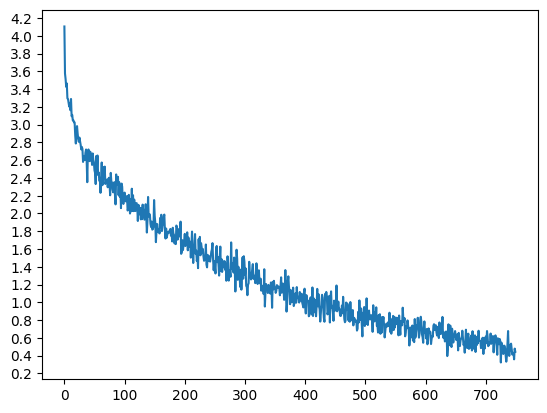

In [ ]:
# Set the size of the hidden layers in both the encoder and decoder RNNs
hidden_size = 256

# Create an instance of the encoder RNN
# It takes input_lang.n_words as the input vocabulary size (i.e., number of unique input tokens)
# and hidden_size as the size of the RNN's hidden state
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)

# Create an instance of the decoder RNN
# It takes hidden_size from the encoder and output_lang.n_words as the output vocabulary size
decoder1 = DecoderRNN(hidden_size, output_lang.n_words).to(device)

# Set the total number of training iterations (i.e., how many sentence pairs to train on)
n_iters = 75000

# Set how often to print the training loss (every 5000 iterations)
print_every = 5000

# Start the training process using the trainIters function defined earlier
# This will train the encoder and decoder over 75,000 sentence pairs,
# printing the average loss every 5000 iterations
trainIters(encoder1, decoder1, n_iters=n_iters, print_every=print_every)

In [ ]:
evaluateRandomly(encoder1, decoder1)

> elle est rapide pour tout .
= she is quick at everything .
< she is everything at everything . <EOS>

> nous n en avons pas termine .
= we re not done .
< we re not done . <EOS>

> il est assez sauvage .
= he is quite a savage .
< he is quite a savage . <EOS>

> t es assez bon .
= you re pretty good .
< you re a good enough . <EOS>

> je suis en danger .
= i m in danger .
< i m in danger . <EOS>

> je m entraine pour le triathlon .
= i m training for the triathlon .
< i m getting up for the . . <EOS>

> j en ai assez de ce temps humide .
= i am fed up with this wet weather .
< i m fed up with this time . . <EOS>

> je suis plein de ressources .
= i m resourceful .
< i m resourceful . <EOS>

> ca va .
= i m fine .
< i m fine with this . <EOS>

> il a besoin d argent .
= he is in need of money .
< he is in need of money . <EOS>



### Part2 - Seq2Seq with Attention
Attention Decoder

If only the context vector is passed between the encoder and decoder, that single vector carries the burden of encoding the entire sentence.

Attention allows the decoder network to “focus” on a different part of the encoder’s outputs for every step of the decoder’s own outputs. First we calculate a set of attention weights. These will be multiplied by the encoder output vectors to create a weighted combination. The result (called attn_applied in the code) should contain information about that specific part of the input sequence, and thus help the decoder choose the right output words.

![attn](https://i.imgur.com/1152PYf.png)


Calculating the attention weights is done with another feed-forward layer `attn`, using the decoder’s input and hidden state as inputs. Because there are sentences of all sizes in the training data, to actually create and train this layer we have to choose a maximum sentence length (input length, for encoder outputs) that it can apply to. Sentences of the maximum length will use all the attention weights, while shorter sentences will only use the first few.

<!-- ![encoder-attn](https://pytorch.org/tutorials/_images/attention-decoder-network.png) -->



<!-- ![encoder-attn](https://pytorch.org/tutorials/_images/attention-decoder-network.png) -->
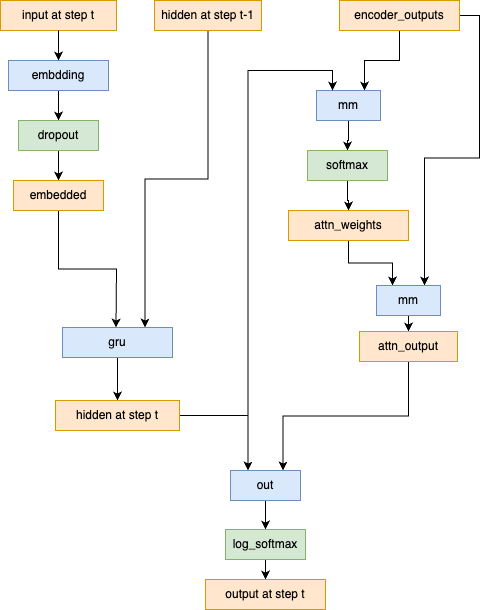

In [ ]:
# Define a decoder with attention mechanism using PyTorch's nn.Module
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        # Initialize the base nn.Module class
        super(AttnDecoderRNN, self).__init__()

        # Save parameters
        self.hidden_size = hidden_size              # Size of the hidden state in GRU
        self.output_size = output_size              # Size of the output vocabulary
        self.dropout_p = dropout_p                  # Dropout probability
        self.max_length = max_length                # Max length for encoder outputs (used for attention)

        # Define layers
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)  # Converts word indices to dense vectors
        self.dropout = nn.Dropout(self.dropout_p)                          # Applies dropout for regularization
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)              # GRU to process the embedded inputs
        self.out = nn.Linear(self.hidden_size * 2, self.output_size)       # Linear layer for generating final output

    def forward(self, input, hidden, encoder_outputs):
        # Embed the input word (1 word) and reshape to (1, 1, hidden_size)
        embedded = self.embedding(input).view(1, 1, -1)

        # Apply dropout to the embedding
        embedded = self.dropout(embedded)

        # Run the GRU with the embedded word and previous hidden state
        _, hidden = self.gru(embedded, hidden)

        # Compute attention weights using dot-product attention:
        # hidden: (1, 1, hidden_size)
        # encoder_outputs: (max_length, hidden_size)
        # First, we need to unsqueeze encoder_outputs to (1, max_length, hidden_size)
        # Then do batch matrix multiply: (1, 1, hidden_size) x (1, hidden_size, max_length)
        attn_weights = F.softmax(
            torch.bmm(hidden, encoder_outputs.T.unsqueeze(0)),
            dim=-1
        )  # Shape: (1, 1, max_length)

        # Apply attention weights to encoder outputs to get context vector
        # attn_weights: (1, 1, max_length)
        # encoder_outputs.unsqueeze(0): (1, max_length, hidden_size)
        attn_output = torch.bmm(attn_weights, encoder_outputs.unsqueeze(0))  # (1, 1, hidden_size)

        # Concatenate attention output and decoder hidden state
        concat_output = torch.cat((attn_output[0], hidden[0]), dim=1)  # (1, hidden_size*2)

        # Pass through linear layer and softmax to get output word probabilities
        output = F.log_softmax(self.out(concat_output), dim=1)  # (1, output_size)

        # Return output word distribution, updated hidden state, and attention weights
        return output, hidden, attn_weights

    def initHidden(self):
        # Create an initial hidden state of zeros
        return torch.zeros(1, 1, self.hidden_size, device=device)

#### Training and evaluation Seq2Seq with Attention models

In [ ]:
# The probability of using teacher forcing during training
teacher_forcing_ratio = 0.5

# This function trains one input-target pair using an encoder and an attention-based decoder
def train_attn(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    # Initialize the hidden state of the encoder
    encoder_hidden = encoder.initHidden()

    # Reset gradients for both optimizers before backpropagation
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Get the lengths of the input and target sequences
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    # Create a tensor to store the encoder’s outputs at each timestep (used for attention)
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    # Initialize loss to 0 for this training example
    loss = 0

    # Pass each input token into the encoder one at a time
    for ei in range(input_length):
        # Get encoder output and updated hidden state
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        # Store the encoder output at this time step
        encoder_outputs[ei] = encoder_output[0, 0]

    # Start the decoder with the <SOS> token
    decoder_input = torch.tensor([[SOS_token]], device=device)

    # Initialize the decoder’s hidden state with the encoder’s final hidden state
    decoder_hidden = encoder_hidden

    # Decide whether to use teacher forcing for this iteration
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Feed the actual target tokens to the decoder at each step (teacher forcing)
        for di in range(target_length):
            # Pass decoder input, hidden state, and encoder outputs to the attention decoder
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            # Compute loss between predicted output and true target token
            loss += criterion(decoder_output, target_tensor[di])
            # Use the actual target token as the next input
            decoder_input = target_tensor[di]

    else:
        # No teacher forcing: feed the decoder’s own prediction as the next input
        for di in range(target_length):
            # Pass current input and hidden state into the decoder
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            # Get the top predicted word index
            topv, topi = decoder_output.topk(1)
            # Use the predicted word as the next input (detach to avoid tracking history)
            decoder_input = topi.squeeze().detach()

            # Compute loss with respect to the true target token
            loss += criterion(decoder_output, target_tensor[di])

            # If the model predicts <EOS>, stop decoding early
            if decoder_input.item() == EOS_token:
                break

    # Compute gradients via backpropagation
    loss.backward()

    # Update the parameters using the computed gradients
    encoder_optimizer.step()
    decoder_optimizer.step()

    # Return average loss per output token for monitoring
    return loss.item() / target_length

In [ ]:
# This function evaluates a trained encoder and attention-based decoder on an input sentence.
def evaluate_attn(encoder, decoder, sentence, max_length=MAX_LENGTH):
    # No gradients are needed during evaluation, so we disable them for efficiency
    with torch.no_grad():
        # Convert the input sentence into a tensor of word indices
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]

        # Initialize the encoder's hidden state
        encoder_hidden = encoder.initHidden()

        # Create a tensor to store encoder outputs (needed for attention)
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        # Pass each token of the input sequence through the encoder
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]  # Save the output for attention use

        # Start decoder with the <SOS> (start-of-sequence) token
        decoder_input = torch.tensor([[SOS_token]], device=device)

        # Use the encoder's final hidden state to initialize the decoder
        decoder_hidden = encoder_hidden

        # List to collect the words predicted by the decoder
        decoded_words = []

        # Tensor to collect attention weights for each decoding step
        decoder_attentions = torch.zeros(max_length, max_length)

        # Begin decoding step-by-step
        for di in range(max_length):
            # Run the decoder with current input, hidden state, and all encoder outputs (for attention)
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)

            # Store the attention weights for this step
            decoder_attentions[di] = decoder_attention.data

            # Get the top predicted word (most likely next word)
            topv, topi = decoder_output.data.topk(1)

            # If the model predicted <EOS>, stop decoding
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                # Otherwise, convert the predicted index to the corresponding word
                decoded_words.append(output_lang.index2word[topi.item()])

            # Use the predicted word as the next input to the decoder
            decoder_input = topi.squeeze().detach()

        # Return the decoded sentence and the collected attention weights
        return decoded_words, decoder_attentions[:di + 1]  # Only return attention up to the last generated word

In [ ]:
def evaluateRandomly_attn(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attention= evaluate_attn(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [ ]:
# This function runs the training loop for attention-based encoder-decoder models
def trainIters_attn(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    # Record the start time so we can report training duration
    start = time.time()

    # Initialize lists and counters to track losses
    plot_losses = []          # Losses to be plotted
    print_loss_total = 0      # Running loss for printing (reset every print_every)
    plot_loss_total = 0       # Running loss for plotting (reset every plot_every)

    # Set up SGD (stochastic gradient descent) optimizers for both encoder and decoder
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

    # Randomly select training sentence pairs and convert them to tensors
    training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]

    # Use negative log-likelihood loss for classification over vocabulary
    criterion = nn.NLLLoss()

    # Main training loop over all iterations
    for iter in range(1, n_iters + 1):
        # Get the input and target tensor for the current training example
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        # Train on this pair using attention-enabled training function
        loss = train_attn(input_tensor, target_tensor, encoder,
                          decoder, encoder_optimizer, decoder_optimizer, criterion)

        # Accumulate loss values
        print_loss_total += loss
        plot_loss_total += loss

        # Every `print_every` iterations, print average loss so far
        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0  # Reset counter
            print('%s (%d %d%%) %.4f' % (
                timeSince(start, iter / n_iters),  # How long training has taken
                iter,                              # Current iteration number
                iter / n_iters * 100,              # Progress percentage
                print_loss_avg                     # Average loss over this interval
            ))

        # Every `plot_every` iterations, save average loss for plotting
        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0  # Reset counter

    # After training, visualize the loss trend over time
    showPlot(plot_losses)

6m 22s (- 89m 8s) (5000 6%) 2.7214
12m 46s (- 83m 0s) (10000 13%) 2.0161
19m 2s (- 76m 11s) (15000 20%) 1.6499
25m 10s (- 69m 12s) (20000 26%) 1.4246
31m 28s (- 62m 56s) (25000 33%) 1.2220
37m 45s (- 56m 38s) (30000 40%) 1.0559
44m 29s (- 50m 50s) (35000 46%) 0.9262
50m 52s (- 44m 30s) (40000 53%) 0.8148
57m 33s (- 38m 22s) (45000 60%) 0.7268
63m 51s (- 31m 55s) (50000 66%) 0.6532
70m 21s (- 25m 35s) (55000 73%) 0.5923
76m 46s (- 19m 11s) (60000 80%) 0.5307
82m 57s (- 12m 45s) (65000 86%) 0.4828
89m 16s (- 6m 22s) (70000 93%) 0.4429
95m 32s (- 0m 0s) (75000 100%) 0.4099


<Figure size 640x480 with 0 Axes>

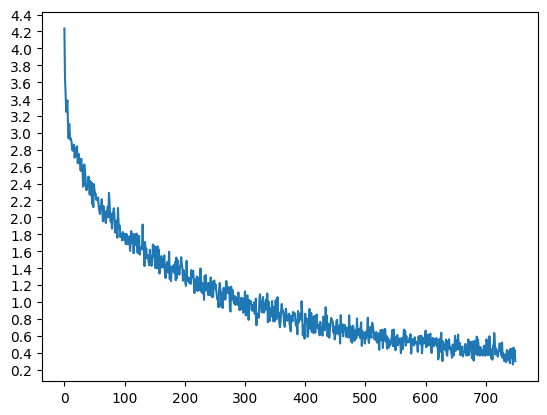

In [ ]:
hidden_size = 256
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

#
n_iters = 75000
print_every = 5000

# about 25 minutes on a T4 GPU via Colab
trainIters_attn(encoder, attn_decoder, n_iters= n_iters, print_every=print_every)

In [ ]:
evaluateRandomly_attn(encoder, attn_decoder)

> j ai les glandes .
= i m really angry .
< i m starved . <EOS>

> mes pensees ne sont pas claires .
= i m not thinking clearly .
< i m not thinking clearly . <EOS>

> je veux presenter mes excuses .
= i m willing to apologize .
< i m willing to apologize . <EOS>

> je vais faire autre chose .
= i m going to do something else .
< i m going to do something else . <EOS>

> c est une bonne danseuse .
= she is a good dancer .
< she is a good dancer . <EOS>

> tu es fort sceptique .
= you re very skeptical .
< you re very skeptical . <EOS>

> je rencontre quelqu un pour diner .
= i m meeting someone for dinner .
< i m meeting someone for dinner . <EOS>

> je suis certain de pouvoir persuader tom .
= i m sure i can persuade tom .
< i m sure i can persuade tom . <EOS>

> je suis sur que vous allez reussir .
= i m confident that you ll succeed .
< i m sure that you ll succeed . <EOS>

> je suis a vos cotes .
= i m by your side .
< i m by your side . <EOS>



#### Visualizing Attention
A useful property of the attention mechanism is its highly interpretable outputs. Because it is used to weight specific encoder outputs of the input sequence, we can imagine looking where the network is focused most at each time step.

You could simply run `plt.matshow(attentions)` to see attention output displayed as a matrix, with the columns being input steps and rows being output steps:

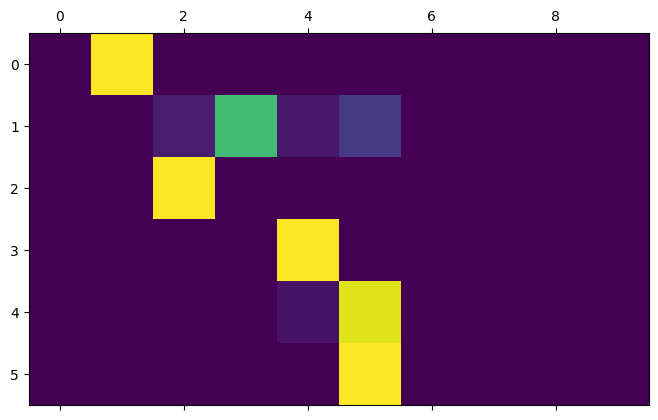

In [ ]:
%matplotlib inline
output_words, attentions = evaluate_attn(
    encoder, attn_decoder, "je suis trop froid .")
plt.matshow(attentions.numpy())

For a better viewing experience we will do the extra work of adding axes and labels:

input = elle a cinq ans de moins que moi .
output = she is five years younger than me . <EOS>


<ipython-input-34-a9d2be5cbafc>:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-34-a9d2be5cbafc>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


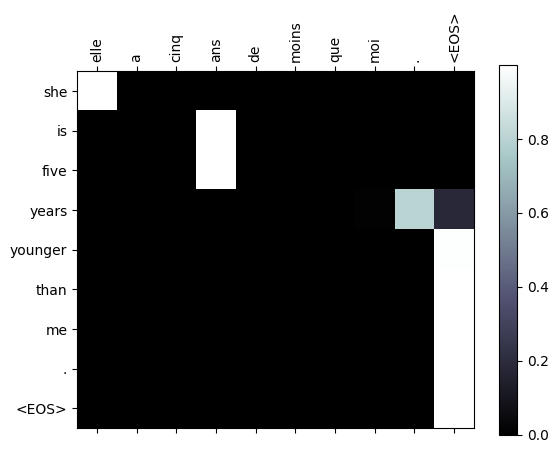

input = elle est trop petit .
output = she s too short . <EOS>


<ipython-input-34-a9d2be5cbafc>:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-34-a9d2be5cbafc>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


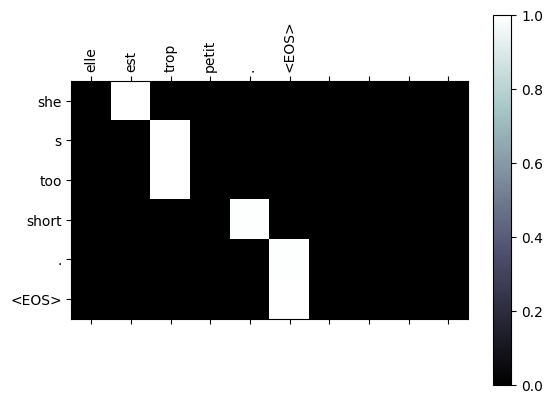

input = je ne crains pas de mourir .
output = i m not scared to die . <EOS>


<ipython-input-34-a9d2be5cbafc>:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-34-a9d2be5cbafc>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


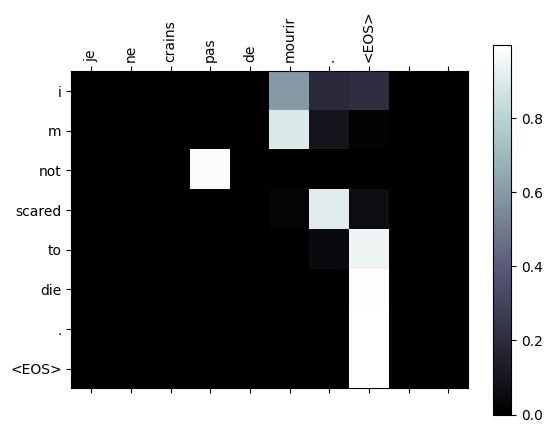

input = c est un jeune directeur plein de talent .
output = he s a talented young . <EOS>


<ipython-input-34-a9d2be5cbafc>:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-34-a9d2be5cbafc>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


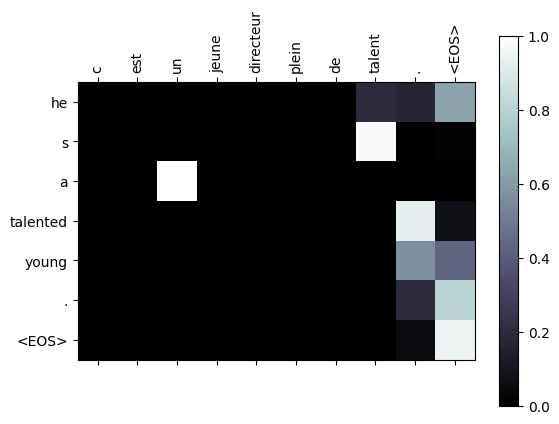

In [ ]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate_attn(
        encoder, attn_decoder, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")

In [ ]:
evaluateRandomly_attn(encoder, attn_decoder)

## Exercises

1. In the tutorial, we train our NMT models on a toy dataset by filtering out sentences with length larger than 10 and only considering training pairs with some special English prefixes (see filterPair and filterPairs methods). Remove this filter and retrain the model on the real Tatoeba dataset. Compare the training time and results.
2. Try with more layers, more hidden units, and more sentences. Compare the training time and results.
3. If you use a translation file where pairs have two of the same phrase (I am test \t I am test), you can use this as an autoencoder. Try this:
- Train as an autoencoder
- Save only the Encoder network
- Train a new Decoder for translation from there
